In [13]:
import numpy as np
import astropy.coordinates as ac
from datetime import datetime
import os
import logging
import astropy.units as un
from glob import glob
from ch_util import ephemeris, tools
import baseband_analysis.core.calibration as cal
from baseband_analysis.core import bbdata
from caput.time import Observer
from baseband_analysis.analysis import beamform


In [14]:
# Shion's modifications, adapted from Juan's code

"""tools for rfi analysis of baseband data"""

import numpy as np
import time
import re
import os
import scipy.linalg as la
import scipy.constants
import baseband_analysis.core as bbcore
from ch_util import ephemeris, tools
from typing import List
import baseband_analysis.core.calibration as cal
from baseband_analysis.analysis.beamform import fringestop_time_vectorized
def clean_persistent_rfi(
    data,
    ra:np.ndarray, 
    dec:np.ndarray, 
    ps_gain_file:str, 
    inputs:List,
    static_delays:bool,
    reference_feed=tools.CHIMEAntenna(
        id=-1, slot=-1, powered=True, flag=True, pos=[0, 0, 0]
    ),
    obs=ephemeris.chime):
    """
    Clean baseband data from persistent RFI
    
    Parameters:
    -----------
    data: core.BBdata
        baseband data
    ps_gain_file: str
        Point source gain file name (full path)
    rfi_channels: array
        List of persistent RFI channel ids to be cleaned
    verbose: bool
        Verbose
    """

    # baseband data info
    timestamp0 = data["time0"]["ctime"] + data["time0"]["ctime_offset"]
    date0 = [datetime.utcfromtimestamp(t) for t in timestamp0]
    timestamp = timestamp0[:, np.newaxis] + data.time[np.newaxis, :]
    N_times = len(timestamp[0])
    f_MHz = data.freq
    N_freqs = len(f_MHz)

    # Get gains (nfreq,ninputs) (ordered to bbdata)
    freq_id_list = data.index_map["freq"]["id"]
    gain = cal.read_gains(ps_gain_file)[freq_id_list] #only get relevent frequencies
    gain_reordered = gain[:, data.input["chan_id"]] # reordered gains by channel input

    # order feed positions (ordered to bbdata)
    converted_data_inputs = data.input.astype(
            [("chan_id", "<u2"), ("correlator_input", "U32")]
        )
    reordered_inputs = tools.reorder_correlator_inputs(
                converted_data_inputs, inputs
            )

    prod_map = np.empty(len(data.input), dtype=[("input_a", "u2"), ("input_b", "u2")])
    prod_map["input_a"] = np.arange(len(data.input))

    reordered_inputs.append(reference_feed)
    prod_map["input_b"] = len(data.input)


    for rfi_ind in range(N_freqs):
        try:
            clean_single_channel(
            data=data,
            ra=ra,
            dec=dec,
            obs=obs,gain_reordered=gain_reordered,
            rfi_ind=rfi_ind,
            prod_map=prod_map,
            reordered_inputs=reordered_inputs,
            static_delays=static_delays
        )
            print(f"successfully cleaned channel {data.freq[rfi_ind]}")

        except Exception as e:
            print(f"WARNING: COULD NOT PROCESS CHANNEL {data.freq[rfi_ind]} due to error: {e}")

    print("%s: RFI cleaning finished" %(time.strftime("%Y%m%dT%H%M%S")))

    return

def clean_single_channel(
    data,
    ra,
    dec,
    obs,
    rfi_ind:int,
    gain_reordered,
    prod_map,
    static_delays,
    reordered_inputs:List
):

    time = (
            data["time0"]["ctime"][rfi_ind] + data["time0"]["ctime_offset"][rfi_ind]
        )
    time = time + data.index_map["time"]["offset_s"][rfi_ind]
    ra_from_src = np.empty(ra.shape[0])
    dec_from_src = np.empty(dec.shape[0])
    for iipoint in range(len(ra)):
        src = ephemeris.skyfield_star_from_ra_dec(ra[iipoint], dec[iipoint])
        (
            ra_from_src[iipoint],
            dec_from_src[iipoint],
        ) = ephemeris.object_coords(src, time, obs=obs)

    # Get list of bad inputs from  gains
    assert np.nanmax(np.abs(gain_reordered[rfi_ind].flatten()))>0, "gains appear to have zeroed out rfi channels!"
    good_inputs_index = np.where(abs(gain_reordered[rfi_ind])>0.)[0]
    good_inputs_index_x = np.array([good_inputs_index[ii] for ii in
                                    range(len(good_inputs_index)) if
                                    reordered_inputs[good_inputs_index[ii]].pol=="E"])
    good_inputs_index_y = np.array([good_inputs_index[ii] for ii in
                                    range(len(good_inputs_index)) if
                                    reordered_inputs[good_inputs_index[ii]].pol=="S"])
    good_inputs_index = [good_inputs_index_x, good_inputs_index_y]
    N_good_inputs = [len(good_inputs_index[pp]) for pp in range(2)]
        
    fringestop_phase = fringestop_time_vectorized(
        time,
        data.freq[rfi_ind],
        reordered_inputs,
        ra_from_src,
        dec_from_src,
        prod_map=prod_map,
        obs=obs,
        static_delays=static_delays,
    ).T.astype(np.complex64)[0]

    ###########################################################################
    ############################ form visibilities ############################
    ###########################################################################
    # Find where NaNs at the end of the timestream are. Same for all inputs
    vis=[]
    for pp in range(2):
        good_inputs_index_pp=good_inputs_index[pp]
        baseband_data=data.baseband[rfi_ind][good_inputs_index_pp] #ninputs, ntime
        baseband_data=baseband_data[:,~np.isnan(baseband_data)[-1]] #remove nans
        NN=len(baseband_data)
        vis.append(mat2utvec(np.tensordot(baseband_data,
                                    baseband_data.conj(),
                                    axes=([-1], [-1]))) / NN)

    # Construct filter
    # The filter matrix has the form np.dot(a, b.T)
    a = []
    b = []

    try:
        for pp in range(2):
            fringestop_phasepp=np.array([fringestop_phase[i] for i in good_inputs_index[pp]])
            fs_phase=mat2utvec(np.conj(fringestop_phasepp[np.newaxis, :])*(
                        fringestop_phasepp[:, np.newaxis]))
            S = utvec2mat(N_good_inputs[pp], fs_phase.conj())
            F = utvec2mat(N_good_inputs[pp], vis[pp]) #should signal be extracted first?
            evalues, R = la.eigh(S, F) #largest eval is last element
            R_dagger = R.T.conj()
            R_dagger_inv = la.inv(R_dagger)
            a.append(R_dagger_inv[:, -1]) #last 
            b.append(R_dagger[-1]) #last row

        for pp in range(2):
            data["baseband"][rfi_ind, good_inputs_index[pp]] = a[pp][:, np.newaxis] * np.sum(
                b[pp][:, np.newaxis] * data["baseband"][rfi_ind, good_inputs_index[pp]],
                axis=0)[np.newaxis, :] #b=R

    except np.linalg.LinAlgError as err:
        time=datetime.now()
        print(
        "{0}: The following LinAlgError ocurred while constructing the RFI filter: {1}".format(
            time.strftime("%Y%m%dT%H%M%S"), err))

def mat2utvec(A):
    """Vectorizes its upper triangle of the (hermitian) matrix A.

    Parameters
    ----------
    A : 2d array
        Hermitian matrix

    Returns
    -------
    1d array with vectorized form of upper triangle of A

    Example
    -------
    if A is a 3x3 matrix then the output vector is
    outvector = [A00, A01, A02, A11, A12, A22]

    See also
    --------
    utvec2mat
    """

    iu = np.triu_indices(np.size(A, 0)) # Indices for upper triangle of A

    return A[iu]


def utvec2mat(n, utvec):
    """Recovers a hermitian matrix a from its upper triangle vectorized version.

     Parameters
     ----------
     n : int
         order of the output hermitian matrix
     utvec : 1d array
         vectorized form of upper triangle of output matrix

    Returns
    -------
    A : 2d array
        hermitian matrix
    """

    iu = np.triu_indices(n)
    A = np.zeros((n, n), dtype=utvec.dtype)
    A[iu] = utvec # Filling uppper triangle of A
    A = A+np.triu(A, 1).conj().T # Filling lower triangle of A
    return A


In [16]:

CHIMELATITUDE = 49.3207092194
CHIMELONGITUDE = -119.6236774310
CHIMEALTITUDE = 555.372

chime_obs = Observer(
    lon=CHIMELONGITUDE,
    lat=CHIMELATITUDE,
    alt=CHIMEALTITUDE,
    lsd_start=datetime(2013, 11, 15),
)

In [19]:
event_id=311637793
source_name='B0919+06'
ra=140.55855583333334
dec=6.649779444444444
ctime=1691956447.7392485 #unix time
telescope='chime'
correlator="FCC" #for chime 
static_delays=True #for chime
reference_feed=tools.CHIMEAntenna(
        id=-1, slot=-1, powered=True, flag=True, pos=[0, 0, 0]
    )
obs=chime_obs
datafiles_all=glob(f'/arc/projects/chime_frb/data/chime/baseband/raw/*/*/*/astro_{event_id}/*.h5')
cal_h5=glob('/arc/projects/chime_frb/data/chime/daily_gain_solutions/hdf5_files/gain_20230813*')[0]
output_file_dir=f'/arc/projects/chime_frb/shiona/rfi_analysis/{event_id}/'
os.umask(0)
os.makedirs(
    output_file_dir, exist_ok=True, mode=0o777
)  # if output directory doesn't exist, create it

out_file=f'{output_file_dir}{event_id}_{telescope}_singlebeam_{source_name}.h5'
print(out_file)
datas=[]
date = datetime.utcfromtimestamp(ctime)
inputs = tools.get_correlator_inputs(date, correlator=correlator)

/arc/projects/chime_frb/shiona/rfi_analysis/311637793/311637793_chime_singlebeam_B0919+06.h5


In [22]:
test_files=[
    '/arc/projects/chime_frb/data/chime/baseband/raw/2023/08/13/astro_311637793/baseband_311637793_811.h5',
    '/arc/projects/chime_frb/data/chime/baseband/raw/2023/08/13/astro_311637793/baseband_311637793_812.h5',
            ]

In [24]:

chunk_size=2
datas=[]
#for i in range(len(datafiles_all)//chunk_size):
for i in range(len(test_files)//chunk_size):
    logging.info(f"{i*chunk_size}-{i*chunk_size+chunk_size} of {len(datafiles_all)} for telescope {telescope}!")
    data = bbdata.BBData.from_acq_h5(datafiles_all[i*chunk_size:i*chunk_size+chunk_size])

    gains = cal.read_gains(cal_h5)
    cal.apply_calibration(data, gains, inputs=inputs)

    clean_persistent_rfi(
        data=data, ra=np.array([ra]), dec=np.array([dec]), ps_gain_file=cal_h5,inputs=inputs,
        reference_feed=reference_feed,static_delays=static_delays,
        obs=chime_obs)

    beamform.tied_array(
            data,
            ra=np.array([ra]),
            dec=np.array([dec]),
            source_name=np.array([source_name]),
            correlator_inputs=inputs,
            obs=obs,
            reference_feed=reference_feed,
            static_delays=static_delays,#telescope_rotation=telescope_rot
        )

    del data["baseband"]
    datas.append(data)
beamformed_rfi_cleaned = bbdata.concatenate(datas)

#beamformed_rfi_cleaned.save(out_file)

successfully cleaned channel 640.234375
successfully cleaned channel 483.203125
20240320T141930: RFI cleaning finished


In [27]:
out_file='/arc/projects/chime_frb/shiona/rfi_analysis/311637793/singlebeams/311637793_chime_singlebeam_B0919+06_clean.h5'
beamformed_original=bbdata.BBData.from_file(out_file)

In [41]:
new_freq_inx=0
beamformed_rfi_cleaned['tiedbeam_baseband'][new_freq_inx,0]

array([ 11043.611 -2107.4653j ,   7321.7456 -446.13565j,
        -3175.0154-1569.7625j , ..., -11938.161  -896.9337j ,
        -4106.2583-4047.8228j ,  -7777.042 -4365.5337j ], dtype=complex64)

In [42]:
org_freq_inx=np.where(beamformed_original.freq==beamformed_rfi_cleaned.freq[new_freq_inx])[0][0]
beamformed_original['tiedbeam_baseband'][org_freq_inx,0]

array([ 11045.375 -2104.5852j,   7323.5996 -436.1562j,
        -3173.242 -1568.3044j, ..., -11938.02   -897.8324j,
        -4118.83  -4053.676j ,  -7780.6646-4344.41j  ], dtype=complex64)

Written to dataset and updated attributes.


/opt/pysetup/.venv/lib/python3.8/site-packages/pycalc11/interface.py:695: UserWarning: No ocean pole tide loading coefficients found for CHIME, KKO
  warnings.warn(
/opt/pysetup/.venv/lib/python3.8/site-packages/pycalc11/interface.py:701: UserWarning: No ocean loading coefficients found for CHIME, KKO
  warnings.warn(


27.0930767059 27.0930767059 0


/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:228: RuntimeWarning: Mean of empty slice
  I[mask, :] = np.nanmean(I, axis=1)[mask, np.newaxis]
/opt/pysetup/baseband_analysis/core/sampling.py:546: RuntimeWarning: Mean of empty slice
  wfall = np.nanmean(
/opt/pysetup/baseband_analysis/core/sampling.py:552: RuntimeWarning: Mean of empty slice
  wfall = np.nanmean(
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:228: RuntimeWarning: Mean of empty slice
  I[mask, :] = np.nanmean(I, axis=1)[mask, np.newaxis]
/opt/pysetup/baseband_analysis/core/sampling.py:546: RuntimeWarning: Mean of empty slice
  wfall = np.nanmean(
/opt/pysetup/baseband_analysis/core/sampling.py:552: RuntimeWarning: Mean of empty slice
  wfall = np.nanmean(
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:228: RuntimeWarning: Mean of empty slice
  I[mask, :] = np.nanmean(I, axis=1)[mask, np.newa

Visibility timestamps being written in baseline mode, i.e. to f"vis[chime-kko/time_a]


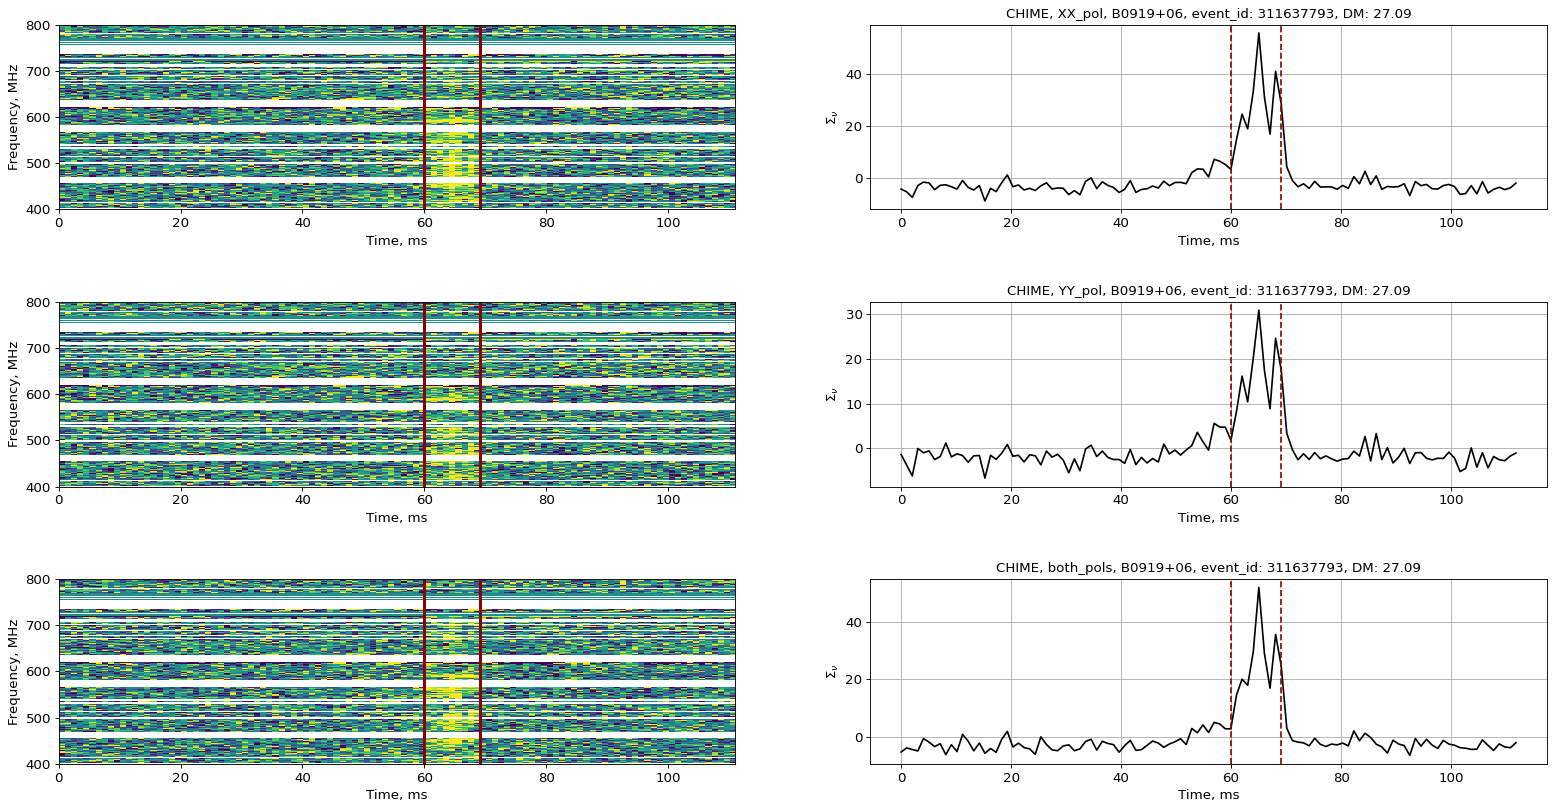

In [56]:
from glob import glob
from coda.core import VLBIVis
from outriggers_vlbi_pipeline.cross_correlate_data import _cross_correlate_data
from outriggers_vlbi_pipeline.vlbi_pipeline_config import chime,kko
main_dir='/arc/projects/chime_frb/shiona/rfi_analysis/311637793/'
from baseband_analysis.core.bbdata import BBData
telescopes=[chime,kko]
chime_bbdata=BBData.from_file(f'{main_dir}singlebeams/311637793_chime_singlebeam_B0919+06_clean.h5')
out_bbdata=BBData.from_file(f'{main_dir}singlebeams/311637793_kko_singlebeam_B0919+06_clean.h5')
tel_bbdatas=[chime_bbdata,out_bbdata]
DM=27.0930767059
vis_target = _cross_correlate_data(
        event_id=311637793,
        tel_bbdatas=tel_bbdatas,
        telescopes=telescopes,
        source_name='B0919+06',
        source_type='target',
        get_autolims=True,
        DM=DM,
)
#    ra=np.array(140.55511352),
#    dec=np.array(6.62110156),

In [57]:
vis_target['chime-kko']['vis'][14,0,0,0,:10]

array([[ 2.7490077e+08-1.1949220e+08j],
       [-2.0460795e+08+1.3679363e+09j],
       [-5.2962724e+07+2.0697516e+09j],
       [ 3.4964592e+08-1.6746822e+09j],
       [-7.2832632e+07-2.1024452e+09j],
       [ 1.4497407e+09-1.2540236e+09j],
       [ 4.0030368e+07+5.5760250e+08j],
       [-3.4066160e+08+4.6204604e+07j],
       [-9.8010250e+06-2.5287542e+08j],
       [ 1.3705589e+08-6.9549254e+08j]], dtype=complex64)

In [76]:
vis_file=f'{main_dir}_B0919+06_unfiltered_vis.h5'
vis_old_unfiltered=VLBIVis.from_file(vis_file)

vis_file=f'{main_dir}_target_B0919+06_vis.h5'
vis_old=VLBIVis.from_file(vis_file)

vis_old['chime-kko']['vis'][14,0,0,0,:10]

array([[ 1.06093325e+09-1.4606598e+08j],
       [-1.31045594e+09-8.3811181e+08j],
       [-1.58641933e+09-4.5366515e+08j],
       [ 1.56189683e+09+1.8436038e+09j],
       [ 2.66584064e+09+1.5020891e+09j],
       [ 1.60695744e+09+1.9945467e+09j],
       [ 1.78005232e+08+5.6426790e+08j],
       [ 9.06864800e+07-6.5324832e+08j],
       [-9.34412320e+07+5.3908870e+08j],
       [-2.51640448e+08+6.0233824e+08j]], dtype=complex64)

In [82]:
from coda.analysis.flagging import undo_channel_mask



[<Axes: title={'center': ' vis for 0-0 pol, snr: 12.5'}, xlabel='frame lag', ylabel='snr'>,
 <Axes: title={'center': ' vis for 1-1 pol, snr: 7.1'}, xlabel='frame lag', ylabel='snr'>]

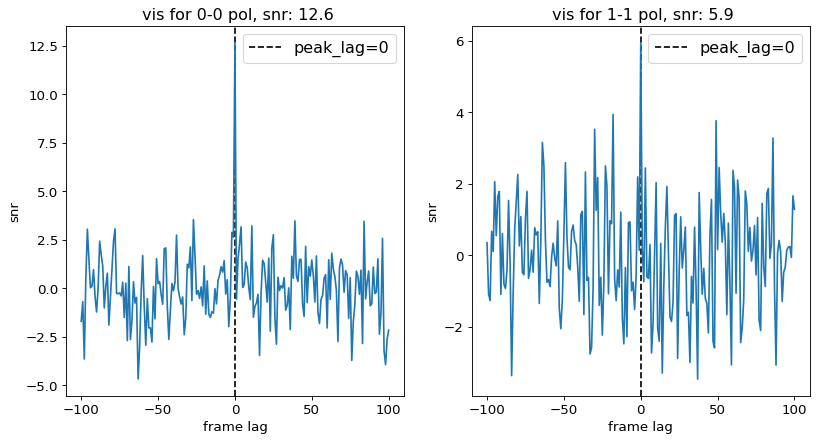

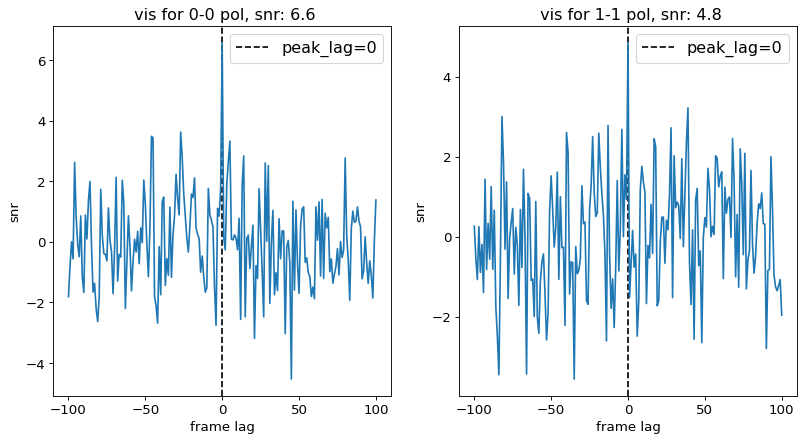

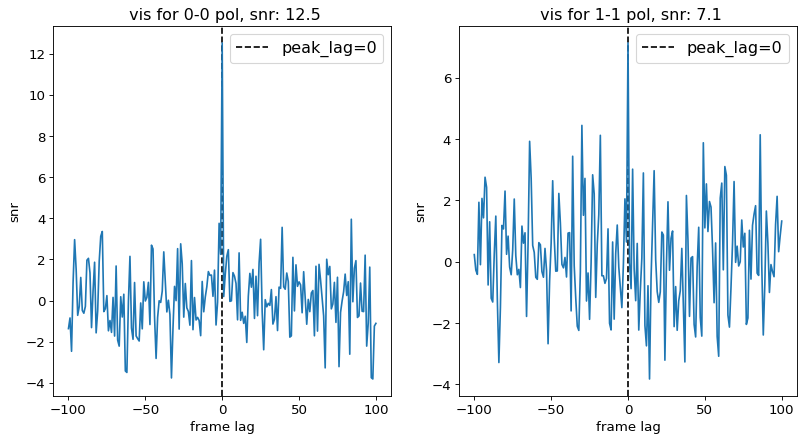

In [77]:
from outriggers_vlbi_pipeline.diagnostic_plots import plot_visibility_diagnostics,plot_cross_correlation_lag


plot_cross_correlation_lag(
    vis_old_unfiltered['chime-kko']['vis'][:],
    event_id=0,
    source_name='')

plot_cross_correlation_lag(
    vis_old['chime-kko']['vis'][:],
    event_id=0,
    source_name='')


plot_cross_correlation_lag(
    vis_target['chime-kko']['vis'][:],
    event_id=0,
    source_name='')

writing vis_error to container


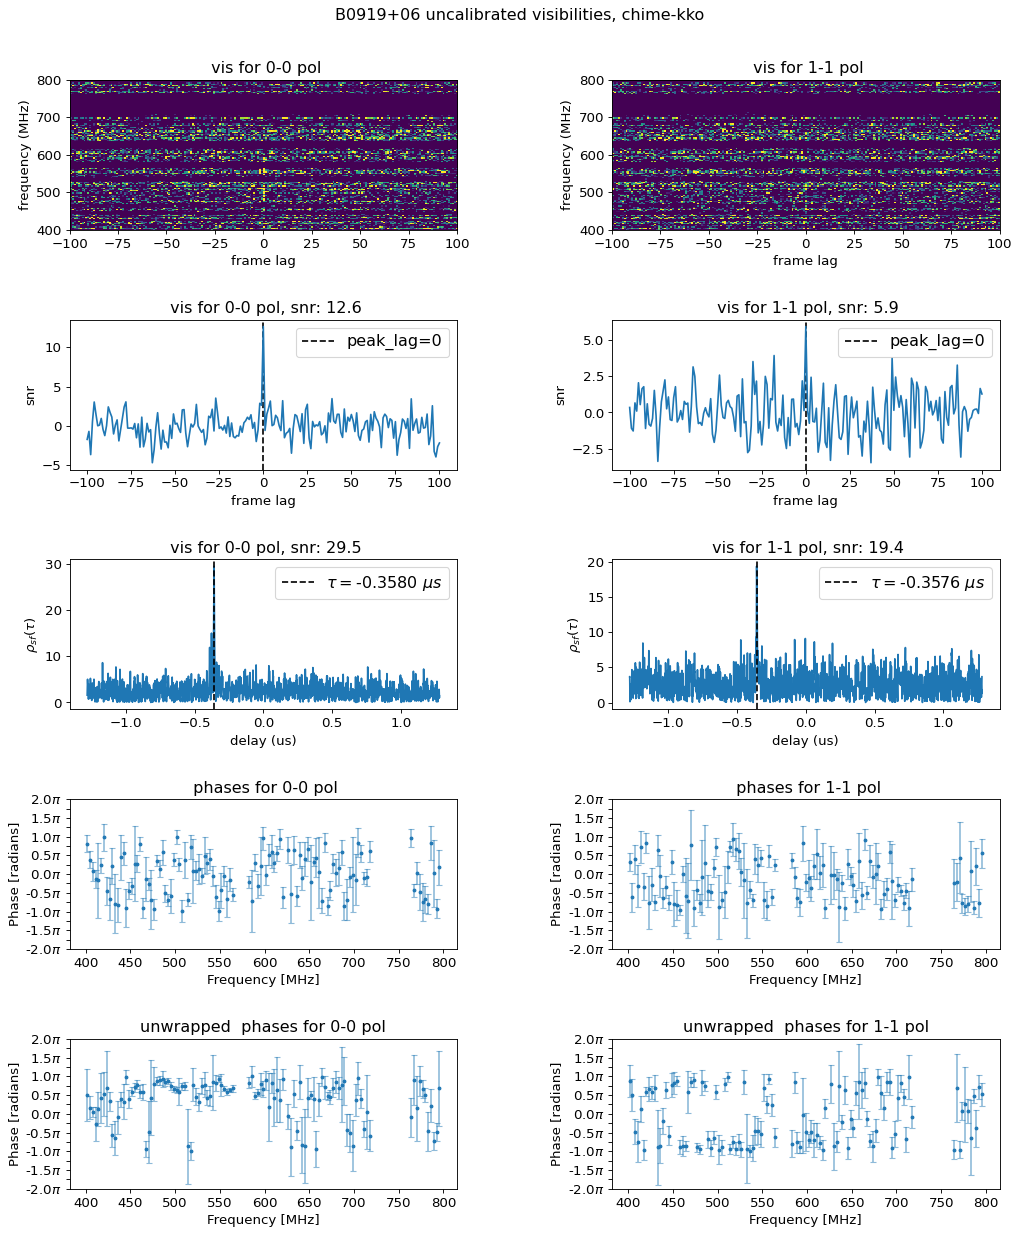

In [83]:
from outriggers_vlbi_pipeline.diagnostic_plots import plot_visibility_diagnostics,plot_cross_correlation_lag

plot_visibility_diagnostics(vlbi_vis=vis_old_unfiltered,baseline='chime-kko',event_id=vis_old.event_id,flag_rfi=False)#,out_file=diagnostics_out_file)


writing vis_error to container


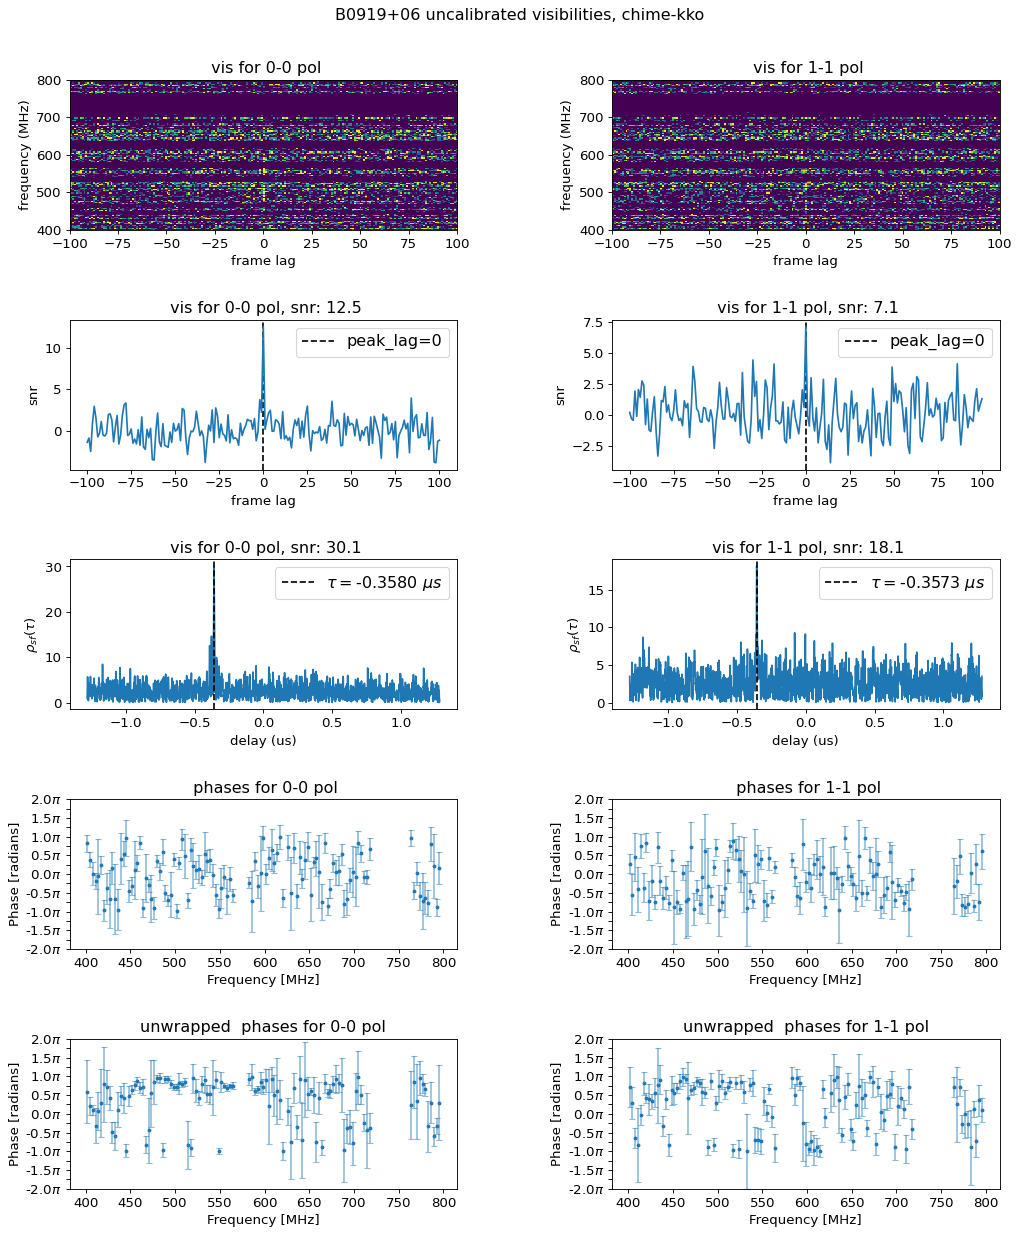

In [61]:
plot_visibility_diagnostics(vlbi_vis=vis_target,baseline='chime-kko',event_id=vis_old.event_id,flag_rfi=False)#,out_file=diagnostics_out_file)
